# QSAR Modelling of Adenosine A2A Receptor Ligands

The goal of this tutorial will be to develop a machine learning model that can capture the Quantitative Structre-Activity Relationships (QSARs) from the data set we extracted from Papyrus [previously](./data_prep.ipynb). This time we will need a little more control than the `scaffviz` package would allow so we load the data file directly into `pandas.DataFrame`:

In [1]:
import pandas as pd

df_all = pd.read_table("data/A2A_LIGANDS.tsv")
df_all.columns

Index(['Activity_ID', 'Quality', 'source', 'CID', 'SMILES', 'connectivity',
       'InChIKey', 'InChI', 'InChI_AuxInfo', 'target_id',
       ...
       'Descriptor_MorganFP_1016', 'Descriptor_MorganFP_1017',
       'Descriptor_MorganFP_1018', 'Descriptor_MorganFP_1019',
       'Descriptor_MorganFP_1020', 'Descriptor_MorganFP_1021',
       'Descriptor_MorganFP_1022', 'Descriptor_MorganFP_1023', 'TSNE_1',
       'TSNE_2'],
      dtype='object', length=1056)

## Assigning Activity Classes

As you can see it has all the feature we previously added to it, including the t-SNE embedding. But in this part of the tutorial we are more interested in the pChEMBL activities. Let's create a histogram of these values to get an idea of a distribution:

<AxesSubplot: >

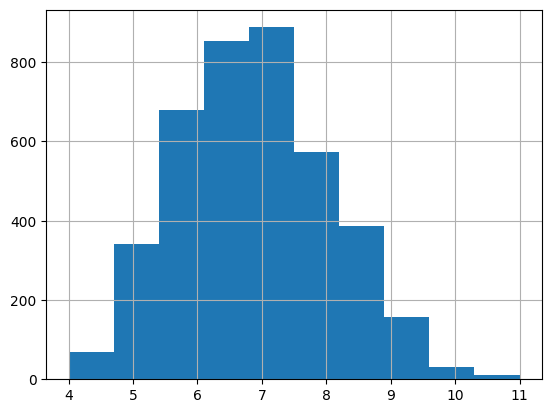

In [2]:
df_all.pchembl_value_Median.hist()

We have a nice normal distribution of values as would be expected, but we also have a fairly balanced ration between inactive and active compounds, which is always a good thing when we are trying to build machine learning models. For example, if we take into account the [previously introduced](data_prep.ipynb) 6.5 threshold that distinguishes actives from inactives, we get reasonably balanced subsets:

In [3]:
activity_class_mask = df_all.pchembl_value_Median >= 6.5
sum(activity_class_mask) / len(activity_class_mask)

0.6071160110248058

Therefore, this split of the data leaves us with about 61% of active molecules. Therefore, we do not need to think much about what to do here for now, but note that for a lot of other data sets the ratio of actives could be much lower and then we might want to think about using some [data balancing techniques](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/).

We will now create a new column in this data set that will serve as the endpoint we want to model (the assignment to an activity class based on molecular structure):

In [4]:
df_all['ActivityClass'] = activity_class_mask
df_all.head()

,Activity_ID,Quality,source,CID,SMILES,connectivity,InChIKey,InChI,InChI_AuxInfo,target_id,...,Descriptor_MorganFP_1017,Descriptor_MorganFP_1018,Descriptor_MorganFP_1019,Descriptor_MorganFP_1020,Descriptor_MorganFP_1021,Descriptor_MorganFP_1022,Descriptor_MorganFP_1023,TSNE_1,TSNE_2,ActivityClass
0,AACWUFIIMOHGSO_on_P29274_WT,High,ChEMBL30,CHEMBL410234,Cc1nn(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n2)c(...,AACWUFIIMOHGSO,AACWUFIIMOHGSO-UHFFFAOYSA-N,InChI=1S/C19H24N6O2/c1-12-10-13(2)25(23-12)17-...,"""AuxInfo=1/1/N:1,26,22,14,15,20,19,11,12,27,6,...",P29274_WT,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-49.262220,-18.827414,True
1,AAEYTMMNWWKSKZ_on_P29274_WT,High,ChEMBL30,CHEMBL601208,Nc1c(C(=O)Nc2ccc([N+](=O)[O-])cc2)sc2c1cc1CCCC...,AAEYTMMNWWKSKZ,AAEYTMMNWWKSKZ-UHFFFAOYSA-N,InChI=1S/C18H16N4O3S/c19-15-13-9-10-3-1-2-4-14...,"""AuxInfo=1/1/N:22,23,21,24,8,15,9,14,19,20,7,1...",P29274_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-30.326859,6.892628,False
2,AAGFKZWKWAMJNP_on_P29274_WT,High,ChEMBL30,CHEMBL473650,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,AAGFKZWKWAMJNP,AAGFKZWKWAMJNP-UHFFFAOYSA-N,InChI=1S/C21H14N6O2/c28-20(14-8-3-1-4-9-14)24-...,"""AuxInfo=1/1/N:27,19,26,28,18,20,9,25,29,17,21...",P29274_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.112610,-4.832593,False
3,AAJLGNFYNMJGSY_on_P29274_WT,High,ExCAPE-DB,9586623,NC(=NC(=O)Cn1c(O)c2CCCCc2c1O)Nc1nc2c(cccc2)s1,AAJLGNFYNMJGSY,AAJLGNFYNMJGSY-UHFFFAOYSA-N,InChI=1S/C18H19N5O3S/c19-17(22-18-20-12-7-3-4-...,"""AuxInfo=1/1/N:12,13,25,24,11,14,26,23,6,10,15...",P29274_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-21.665638,-12.843870,False
4,AANUKDYJZPKTKN_on_P29274_WT,High,ChEMBL30,CHEMBL573125;45483959;CHEMBL573125;45483959;CH...,CNC(=O)C12CC1C(n1cnc3c1nc(C#CCCCCC(=O)OC)nc3NC...,AANUKDYJZPKTKN,AANUKDYJZPKTKN-UHFFFAOYSA-N,InChI=1S/C28H31ClN6O5/c1-30-27(39)28-13-18(28)...,"""AuxInfo=1/1/N:1,25,18,19,17,20,35,36,34,16,21...",P29274_WT,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.994354,38.663483,False


## Creating a Test Set

A lot has been written about [selecting appropriate test sets for machine learning](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/) and indeed that should always be an important first step. The purpose of the test set is to get us an idea on future/prospective performance of our model on unknown data. In QSAR, a popular choice is to make a 'time split' of the data based on publication year: 

In [5]:
cutoff_year = 2015
sum(df_all.Year >= cutoff_year) / len(df_all)

0.19393635680280633

If we train our model on data before year 2015, we could get an idea about how it could perform on data that was not known yet at that time. This approach also has plenty of caveats, one being that the data can follow a different development pattern over time. For example, it can happen that many more chemically novel molecules were found after 2015 making it much harder for the model when previously many chemically related structurues were explored. Fluctuations like these over time can make it harder to find an appropriate split and can result in some unfair comparison so one should always think twice when applying such a split. Here we base our decision solely on the fact that split on year 2015 lands around 20% of the data set in the test set, which is good enough for us, but does not mean it should be good enough for you in every situation. Let's now save our 'Train' and 'Test' set assignment into the data set:

In [6]:
df_all["TimeSplit"] = (df_all.Year >= cutoff_year).apply(lambda x : "Test" if x else "Train")
df_all

,Activity_ID,Quality,source,CID,SMILES,connectivity,InChIKey,InChI,InChI_AuxInfo,target_id,...,Descriptor_MorganFP_1018,Descriptor_MorganFP_1019,Descriptor_MorganFP_1020,Descriptor_MorganFP_1021,Descriptor_MorganFP_1022,Descriptor_MorganFP_1023,TSNE_1,TSNE_2,ActivityClass,TimeSplit
0,AACWUFIIMOHGSO_on_P29274_WT,High,ChEMBL30,CHEMBL410234,Cc1nn(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n2)c(...,AACWUFIIMOHGSO,AACWUFIIMOHGSO-UHFFFAOYSA-N,InChI=1S/C19H24N6O2/c1-12-10-13(2)25(23-12)17-...,"""AuxInfo=1/1/N:1,26,22,14,15,20,19,11,12,27,6,...",P29274_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,-49.262220,-18.827414,True,Train
1,AAEYTMMNWWKSKZ_on_P29274_WT,High,ChEMBL30,CHEMBL601208,Nc1c(C(=O)Nc2ccc([N+](=O)[O-])cc2)sc2c1cc1CCCC...,AAEYTMMNWWKSKZ,AAEYTMMNWWKSKZ-UHFFFAOYSA-N,InChI=1S/C18H16N4O3S/c19-15-13-9-10-3-1-2-4-14...,"""AuxInfo=1/1/N:22,23,21,24,8,15,9,14,19,20,7,1...",P29274_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,-30.326859,6.892628,False,Train
2,AAGFKZWKWAMJNP_on_P29274_WT,High,ChEMBL30,CHEMBL473650,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,AAGFKZWKWAMJNP,AAGFKZWKWAMJNP-UHFFFAOYSA-N,InChI=1S/C21H14N6O2/c28-20(14-8-3-1-4-9-14)24-...,"""AuxInfo=1/1/N:27,19,26,28,18,20,9,25,29,17,21...",P29274_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,25.112610,-4.832593,False,Train
3,AAJLGNFYNMJGSY_on_P29274_WT,High,ExCAPE-DB,9586623,NC(=NC(=O)Cn1c(O)c2CCCCc2c1O)Nc1nc2c(cccc2)s1,AAJLGNFYNMJGSY,AAJLGNFYNMJGSY-UHFFFAOYSA-N,InChI=1S/C18H19N5O3S/c19-17(22-18-20-12-7-3-4-...,"""AuxInfo=1/1/N:12,13,25,24,11,14,26,23,6,10,15...",P29274_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,-21.665638,-12.843870,False,Train
4,AANUKDYJZPKTKN_on_P29274_WT,High,ChEMBL30,CHEMBL573125;45483959;CHEMBL573125;45483959;CH...,CNC(=O)C12CC1C(n1cnc3c1nc(C#CCCCCC(=O)OC)nc3NC...,AANUKDYJZPKTKN,AANUKDYJZPKTKN-UHFFFAOYSA-N,InChI=1S/C28H31ClN6O5/c1-30-27(39)28-13-18(28)...,"""AuxInfo=1/1/N:1,25,18,19,17,20,35,36,34,16,21...",P29274_WT,...,0.0,1.0,0.0,0.0,0.0,0.0,6.994354,38.663483,False,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3986,ZYXGKENMDDPQIE_on_P29274_WT,High,ChEMBL30,CHEMBL4283826,CNc1ncc(C(=O)NCc2ccc(OC)cc2)c2nc(-c3ccco3)nn12,ZYXGKENMDDPQIE,ZYXGKENMDDPQIE-UHFFFAOYSA-N,InChI=1S/C19H18N6O3/c1-20-19-22-11-14(17-23-16...,"""AuxInfo=1/1/N:1,16,24,23,12,18,13,17,25,10,5,...",P29274_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,29.856173,-70.698350,True,Test
3987,ZYZWFDVXMLCIOU_on_P29274_WT,High,ChEMBL30,CHEMBL260989;10132473;CHEMBL260989;10132473;CH...,Nc1nc(-c2ccco2)c2ncn(C(=O)NCCc3ccccc3)c2n1,ZYZWFDVXMLCIOU,ZYZWFDVXMLCIOU-UHFFFAOYSA-N,InChI=1S/C18H16N6O2/c19-17-22-14(13-7-4-10-26-...,"""AuxInfo=1/1/N:22,21,23,7,20,24,6,18,17,8,12,1...",P29274_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,-11.900303,-42.615310,True,Train
3988,ZZBZWSYDXUPJCT_on_P29274_WT,High,ChEMBL30,CHEMBL600404,Nc1nc(Nc2ccc(F)cc2)nc(CSc2nnc(N)s2)n1,ZZBZWSYDXUPJCT,ZZBZWSYDXUPJCT-UHFFFAOYSA-N,InChI=1S/C12H11FN8S2/c13-6-1-3-7(4-2-6)16-11-1...,"""AuxInfo=1/1/N:8,11,7,12,15,9,6,14,2,20,4,17,1...",P29274_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.871733,13.171981,False,Train
3989,ZZMIPZLRKFEGIA_on_P29274_WT,High,ChEMBL30,CHEMBL2312988;71563052;CHEMBL2312988;71563052;...,CCCOc1ccc(C=Cc2cc3c(c(=O)n(C)c(=O)n3C)n2C)cc1,ZZMIPZLRKFEGIA,ZZMIPZLRKFEGIA-UHFFFAOYSA-N,InChI=1S/C20H23N3O3/c1-5-12-26-16-10-7-14(8-11...,"""AuxInfo=1/0/N:1,24,22,18,2,9,7,25,10,6,26,3,1...",P29274_WT,...,0.0,0.0,0.0,0.0,0.0,0.0,46.046997,12.641930,True,Train


Now, we can use the `scaffviz` package again to visualize how different our test set is from the training set. This will be useful to assess how difficult the test set is for the resulting model. We start by saving our annotated data set into a new file and wrapping it as a `DataSetTSV` instance for plotting:

In [7]:
from scaffviz.data.dataset import DataSetTSV

dataset = DataSetTSV(data=df_all, path='data/A2A_LIGANDS_qsar.tsv')

Next, we can just drop it into the `Plot.plot` method again: 

*Note: We should still have the embedding calculated from the previous exercise, but if you do not have that information anymore, it will be recalculated.*

In [8]:
from scaffviz.depiction.plot import Plot
from scaffviz.clustering.manifold import TSNE

plot = Plot(dataset, TSNE())
plot.plot(
    recalculate=False, 
    color_by="TimeSplit",
    color_style="groups",
    card_data=["pchembl_value_Median", "all_doc_ids", "source"],
    title_data="Activity_ID",
    viewport_height=800,
    port=9191
)

/home/sichom/software/miniconda/envs/drugex-demo/lib/python3.9/site-packages/molplotly/main.py:32: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.

/home/sichom/software/miniconda/envs/drugex-demo/lib/python3.9/site-packages/molplotly/main.py:76: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



In the plot, we can see that some of the test compounds are in similar parts of chemical space as the training compounds, but there are also a few 'lonely' compounds that cluster together. So the split we selected actually seems to have a good balance between compounds that are challenging (more distant from the training data) and easier (closer to the training data).

## Model Training

First, we seperate the testing part of the data set and start preparing our training set for modelling:

In [9]:
df_train = df_all[df_all.TimeSplit == "Train"]
len(df_train)

3217

In [10]:
df_test = df_all[df_all.TimeSplit == "Test"]
len(df_test)

774

And finally a quick sanity check that we truly seperated the data correctly by year:

<AxesSubplot: >

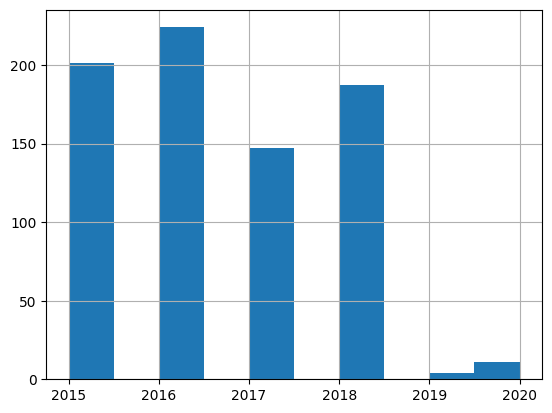

In [11]:
df_test.Year.hist()

Next, we extract the descriptors we will use to derive the QSAR model. This is how we will relate structural information with the endpoint variable (the `ActivityClass` group). The model will need two types of inputs:

1. The data describing molecular structure. In our case, these will be the fingerprints we also used to make the t-SNE plot above.
2. The categorization to `ActivityClass`. This will be used to fit the model and create the mathematical links between the structure (the fingerprints) and the categorization variable (`ActivityClass`).

All descriptor column names start with the `Descriptor_` string so that allows us to extract them easily from the data:

In [12]:
X = df_train[df_train.columns[df_train.columns.str.startswith("Descriptor_")]]
X

,Descriptor_MorganFP_0,Descriptor_MorganFP_1,Descriptor_MorganFP_2,Descriptor_MorganFP_3,Descriptor_MorganFP_4,Descriptor_MorganFP_5,Descriptor_MorganFP_6,Descriptor_MorganFP_7,Descriptor_MorganFP_8,Descriptor_MorganFP_9,...,Descriptor_MorganFP_1014,Descriptor_MorganFP_1015,Descriptor_MorganFP_1016,Descriptor_MorganFP_1017,Descriptor_MorganFP_1018,Descriptor_MorganFP_1019,Descriptor_MorganFP_1020,Descriptor_MorganFP_1021,Descriptor_MorganFP_1022,Descriptor_MorganFP_1023
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The classification is just the `ActivityClass` column:

In [14]:
y = df_train.ActivityClass
y

0        True
1       False
2       False
3       False
4       False
        ...  
3984     True
3987     True
3988    False
3989     True
3990     True
Name: ActivityClass, Length: 3217, dtype: bool

Finally, we can train our classifier. That alone is usually a lengthy process of trial and error during which you may want to tune the kind of machine learning algorithms you want to use and their hyper-parameters (i.e. `n_estimators` for the `ExtraTreesClassifier` algorithm we will be using). However, you may also want to explore different validation strategies as well as data balancing methods as hinted at previously. To make this tutorial as simple as possible, we will just opt for a simple n-fold cross-validation approach. 

First, let us define our model:

In [15]:
from sklearn.ensemble import ExtraTreesClassifier

classifier = ExtraTreesClassifier(n_estimators=250)

We will fix the parameters of this models for simplicity and dive right into [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)). Under this scheme, the model is trained multiple times and its performance validated n times:

![CV](https://upload.wikimedia.org/wikipedia/commons/1/1c/K-fold_cross_validation_EN.jpg)

Picture Credit: [WikiMedia Commons](https://commons.wikimedia.org/wiki/File:K-fold_cross_validation_EN.svg), Gufosowa

The purpose of this exercise is to give us a good idea of the algorithm's ability to learn the QSAR patterns in the data and to accurately predict the `ActivityClass` for unseen data points. It is a common strategy to compare multiple models or the same model with different hyper-parameters. The [`scikit-learn`](https://scikit-learn.org/stable/modules/cross_validation.html) documentation provides and excellent example that allows us to just plugin our classifier into the workflow:

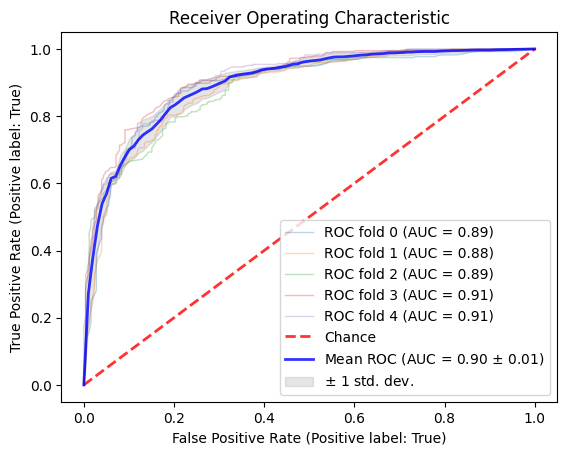

In [16]:
# adapted from https://scikit-learn.org/stable/modules/cross_validation.html

import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[train], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[test],
        y.iloc[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver Operating Characteristic",
)
ax.legend(loc="lower right")
plt.show()

Good news! Our model on average performed much better than random (red dashed line) and it was also stable across folds (small variation from the mean ROC in blue). Therefore, we can now be confident that this model could also perform well on our test data. All we have to do is find out at this point.

## Validation on the Test Set

Finally, it is time to use our test set and find out how predictive our model really is. First, we train the model on the entire training set:

In [19]:
model = classifier.fit(X, y)

and then we make the predictions for our test data:

In [20]:
X_test = df_test[df_test.columns[df_test.columns.str.startswith("Descriptor_")]]

predictions = classifier.predict(X_test)
predictions[0:10]

array([ True, False,  True, False, False, False,  True, False,  True,
        True])

This gives us directly the labels the model thinks our test data should have, but we can also get a more fine-grained idea by extracting the probabilites as well:

In [21]:
predictions_proba = classifier.predict_proba(X_test)[::,1]
predictions_proba[0:10]

array([0.912, 0.324, 0.876, 0.384, 0.408, 0.284, 0.796, 0.392, 0.516,
       0.752])

These are numbers between 0 and 1 that indicate how the model is confident about the compound being active, large values mean the model is fairly confident about the compound being an A2A receptor binder. 

Finally, we compare these predictions with the true values from the test set:

In [22]:
y_test = df_test.ActivityClass
y_test

6       False
7       False
14       True
51      False
54      False
        ...  
3969    False
3976    False
3980    False
3985    False
3986     True
Name: ActivityClass, Length: 774, dtype: bool

The probabilities effectively give us a ranking of the compounds from the most likely actives to the least likely and we can use them to draw an ROC curve like we saw during cross-validation:

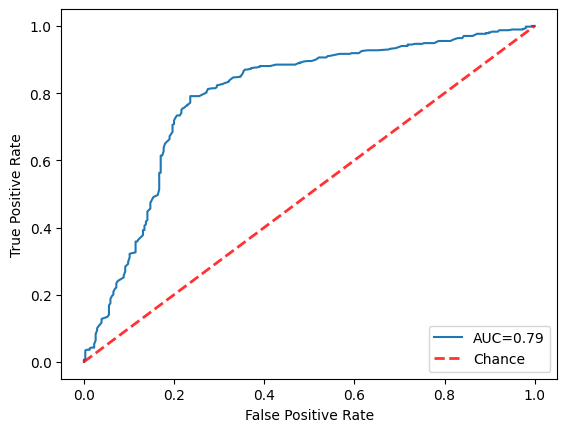

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test,  predictions_proba)
auc = roc_auc_score(y_test, predictions_proba)

plt.plot(fpr,tpr, label=f"AUC={auc:2.2}")
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Clearly, our model has difficulties in this data set and even though the AUC is reasonably high, the compounds ranked the highest (left part of the curve) are not always the actives. This is very common to see in virtual screening. The highest ranking compounds are not always the active ones, but we can still see the model gives us significant enrichment when compared with a random model that would draw compounds by chance (red line).

We can calculate many classification metrics this way and evaluate various aspects of our model. For example, we can directly use the predictions to calculate Matthew's correlation coefficient that gives us a balanced score of how the classifier can label the data: 

In [24]:
from sklearn.metrics import matthews_corrcoef

matthews_corrcoef(y_test, predictions)

0.525492957937103

The best score the model could obtain is 1 so even though this is not ideal, it is still not bad because the value of 0 would be a random model here. With this, let's deem our model fit for use in future endeavors and train the final version on the whole data set:

In [26]:
X = dataset.getDescriptors()
y = dataset.getSubset(('ActivityClass',)).iloc[::,0]

In [27]:
classifier.fit(X, y)
classifier

ExtraTreesClassifier(n_estimators=250)

This is our final model so we might want to save it for future use:

In [28]:
import joblib
import os

data_dir = 'data/qsar/models/'
data_file = os.path.join(data_dir, 'A2A_CLS_ET_250.pickle')
os.makedirs(data_dir, exist_ok=True)
joblib.dump(classifier, data_file)

['data/qsar/models/A2A_CLS_ET_250.pickle']

This means we can easily load it whenever we need it in this tutorial, which will come right in the [next section](de_novo.ipynb):

In [29]:
model = joblib.load(data_file)
model

ExtraTreesClassifier(n_estimators=250)